In [1]:
import arviz as az
import numpy as np
import os.path as op
import pandas as pd

import seaborn as sns
from bauer.utils.plotting import plot_prediction
import matplotlib.pyplot as plt
from tms_risk.cogmodels.fit_model import build_model, get_data
from bauer.utils.math import softplus_np
from tms_risk.cogmodels.utils import plot_ppc
import pymc as pm

from bauer.models import FlexibleNoiseRiskRegressionModel

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)


def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return FlexibleNoiseRiskRegressionModel.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

def get_ppc(model, idata, df):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

    return ppc

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

bids_folder = '/data/ds-tmsrisk'

In [2]:
def get_pars(idata, group=True):
    traces = {}

    pars_vertex = []
    pars_ips = []

    keys = ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

    for key in keys:

        if group:
            key_ = key+'_mu'
        else:
            key_ = key
        
        if key_ in idata.posterior.keys():
            print(key_)

            traces[key] = idata.posterior[f'{key_}'].to_dataframe()

            ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')


            if 'stimulation_condition[T.vertex]' in traces[key].index.get_level_values(f'{key}_regressors'):
                vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
            else:
                vertex_values = ips_values

            if (key in ['n1_evidence_sd', 'n2_evidence_sd']) and 'evidence_sd' in idata.posterior.keys():
                if group:
                    key__ = 'evidence_sd_mu'
                else:
                    key__ = 'evidence_sd'
                
                print('yo')
                ips_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[ips]', 0, f'evidence_sd_regressors').values
                vertex_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[vertex]', 0, f'evidence_sd_regressors').values


            if key in ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
                ips_values = softplus_np(ips_values)
                vertex_values = softplus_np(vertex_values)

            pars_ips.append(ips_values)
            pars_vertex.append(vertex_values)


    pars_ips = pd.concat(pars_ips, axis=1)
    pars_vertex = pd.concat(pars_vertex, axis=1)

    pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
    pars.columns.name = 'parameter'
    pars = pars.stack().to_frame('value')

    return pars


def plot_pars(pars, df, ):
    g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

    g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
    g.set_titles('{col_name}')


    g.axes.flat[0].axhline(df['n_risky'].mean(), color='k', linestyle='--')
    g.axes.flat[1].axhline(df['n_risky'].std(), color='k', linestyle='--')
    g.axes.flat[2].axhline(df['n_safe'].mean(), color='k', linestyle='--')
    g.axes.flat[3].axhline(df['n_safe'].std(), color='k', linestyle='--')

    return g

def get_info(model_label, bids_folder='/data/ds-tmsrisk'):
    df = get_data(bids_folder, model_label)
    model = build_model(model_label, df)
    model.build_estimation_model()
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))


    return df, model, idata

# Flexible 1

In [3]:
df = get_data(model_label='flexible1')
model = build_model(df=df, model_label='flexible1')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible1_trace.netcdf'))

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:279: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '20%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', '32%', 

Dropping the baseline condition
{'n1_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 

/Users/gdehol/git/bauer/bauer/models.py:1488: UserWarning: Found n1_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')
/Users/gdehol/git/bauer/bauer/models.py:1488: UserWarning: Found n2_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')


array([[<Axes: title={'center': 'n1_evidence_sd_spline1_mu'}>,
        <Axes: title={'center': 'n1_evidence_sd_spline1_mu'}>]],
      dtype=object)

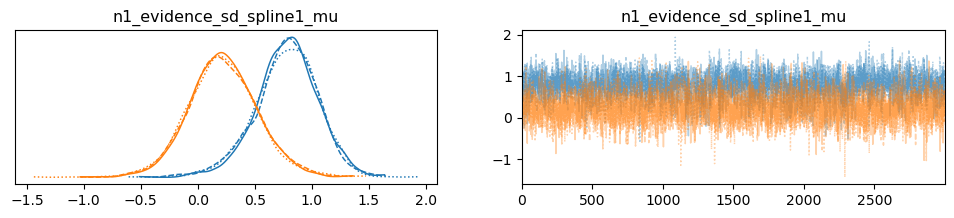

In [18]:
az.plot_trace(idata.sel(chain=[0, 1, 3]), var_names=['n1_evidence_sd_spline1_mu'])

In [19]:
idata = idata.sel(chain=[0, 1, 3])


In [20]:
n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_spline{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(1, 6)], axis=1)
n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_spline{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(1, 6)], axis=1) + pd.concat([idata.posterior[f'n1_evidence_sd_spline{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(1, 6)], axis=1).values

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_spline{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(1, 6)], axis=1)
n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_spline{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(1, 6)], axis=1) + pd.concat([idata.posterior[f'n2_evidence_sd_spline{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(1,  6)], axis=1).values

x = np.arange(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(5)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

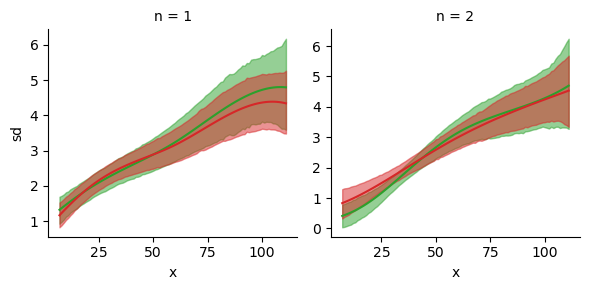

In [21]:

import seaborn as sns

g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_order=[1, 2], hue_order=stimulation_order, sharey=False)

g.map_dataframe(plot_prediction, x='x', y='sd')
# g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

g = sns.FacetGrid(curve_stats.reset_index(), col='TMS', hue='n', palette=sns.color_palette('coolwarm', 2), sharey=False)

g.map_dataframe(plot_prediction, x='x', y='sd')
g.add_legend()

(7.0, 60.0)

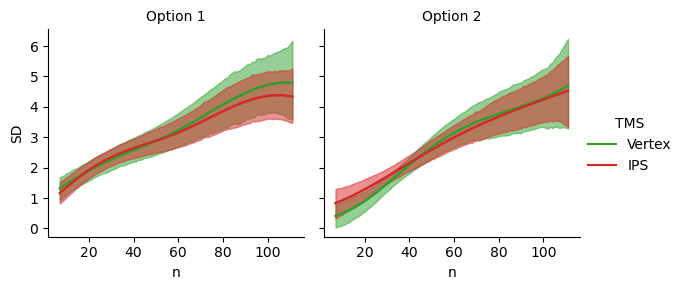

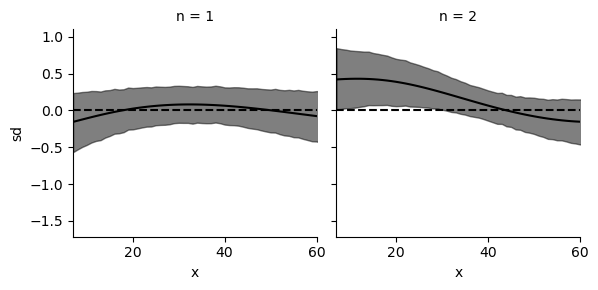

In [22]:
g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_evidence_sd.pdf'))

tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 60)
# g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_evidence_sd_diff.pdf'))

(7.0, 28.0)

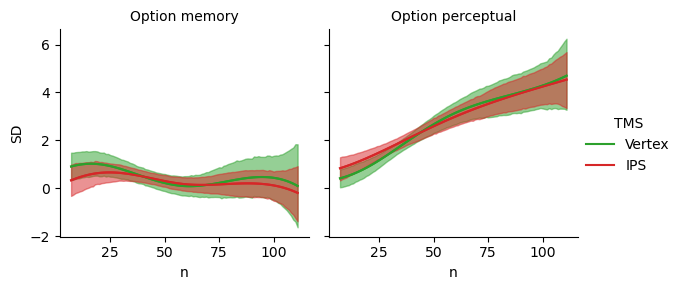

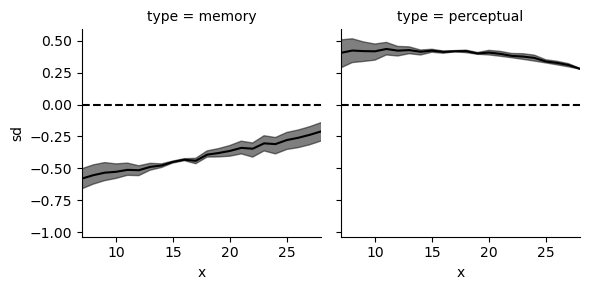

In [23]:
memory_curve_posterior = curve_posterior.loc[1] - curve_posterior.loc[2]
perceptual_curve_posterior = curve_posterior.loc[2]

repar_curve_posterior = pd.concat((memory_curve_posterior, perceptual_curve_posterior), keys=['memory', 'perceptual'], names=['type'], axis=0)

repar_curve_posterior_stats = repar_curve_posterior.groupby(['type', 'TMS']).apply(lambda d: model.get_sd_curve_stats(d.stack().to_frame('sd')))
repar_curve_posterior_stats = repar_curve_posterior.groupby(['type', 'TMS']).apply(lambda d: model.get_sd_curve_stats(d.stack().to_frame('sd')))
g = sns.FacetGrid(repar_curve_posterior_stats.reset_index(), col='type', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_repar_evidence_sd.pdf'))

tmp = repar_curve_posterior_stats.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby=['type'])

g = sns.FacetGrid(diff_stats.reset_index(), col='type')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 28)
# g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_repar_evidence_sd_diff.pdf'))

risky_prior_mu_mu
safe_prior_mu_mu
Unexpected exception formatting exception. Falling back to standard exception


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_13545/3162720075.py", line 2, in <module>
    g = plot_pars(pars, df)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_13545/2312319608.py", line 61, in plot_pars
    g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py", line 758, in map
    self.

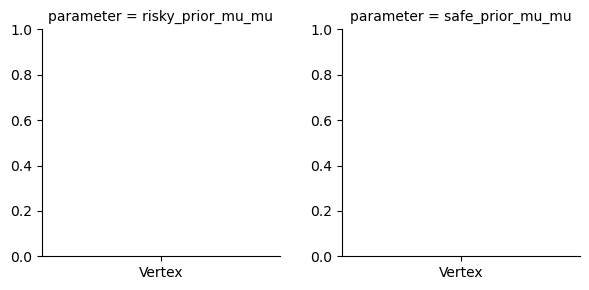

In [24]:
pars = get_pars(idata)
g = plot_pars(pars, df)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_pars.pdf'))

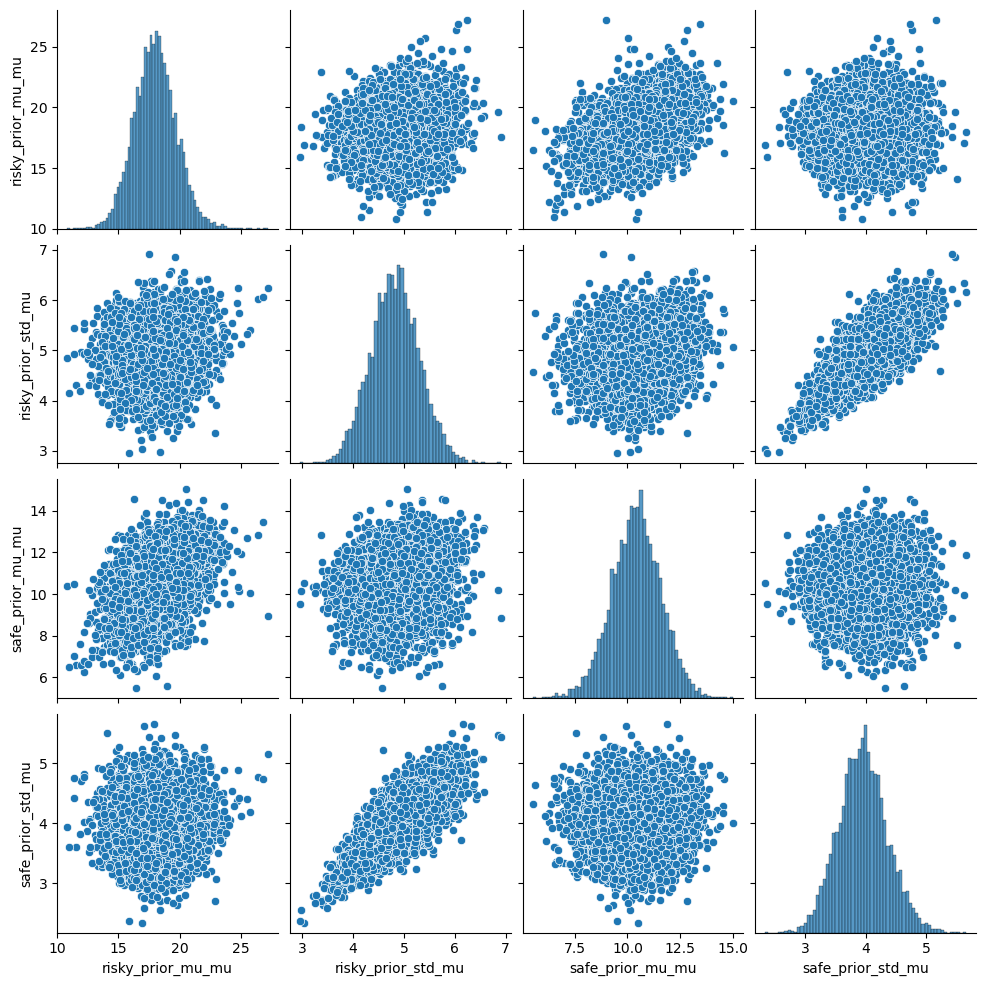

In [ ]:
sns.pairplot(pars.unstack('parameter').loc['IPS']['value'])

In [37]:
model.build_estimation_model()
model.ppc(df, idata)

{'n1_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'risky_prior_mu': {

Sampling: [ll_bernoulli]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pytensor/link/basic.py", line 102, in __set__
    self.storage[0] = self.type.filter_inplace(
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pytensor/graph/type.py", line 130, in filter_inplace
    raise NotImplementedError()
NotImplementedError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_2340/2209441419.py", line 2, in <module>
    model.ppc(df, idata)
  File "/Users/gdehol/git/bauer/bauer/core.py", line 228, in ppc
    idata = pm.sample_posterior_predictive(idata, var_names=var_names)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pymc/sampling/forward.py", line 

In [6]:
model.build_estimation_model()
ppc = model.ppc(idata=idata.sel(draw=slice(None, None, 10)), paradigm=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

{'n1_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'risky_prior_mu': {

Sampling: [ll_bernoulli]


In [9]:
from tms_risk.cogmodels.utils import plot_ppc

In [12]:
from tms_risk.cogmodels.utils import cluster_offers, summarize_ppc, plot_prediction

def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5, legend=True, **kwargs):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', 'log(risky/safe)']).size().groupby('subject').size() < 7).all():
        df['log(risky/safe)'] = df.groupby(['subject'],
                                        group_keys=False).apply(cluster_offers)
        # df = df.set_index('log(risky/safe)', append=True)

    print(df)

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc.reset_index('log(risky/safe)', drop=True, inplace=True)
        # ppc.set_index(df['log(risky/safe)'], append=True, inplace=True)
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')
        ppc.set_index('log(risky/safe)', append=True, inplace=True)

    if plot_type == 0:
        groupby = ['log(risky/safe)', 'stimulation_condition']
    elif plot_type == 1:
        groupby = ['risky_first', 'log(risky/safe)']
    elif plot_type in [2, 4]:
        groupby = ['risky_first', 'n_safe']
    elif plot_type in [3, 5]:
        groupby = ['risky_first', 'n_safe', 'log(risky/safe)']
    elif plot_type in [6]:
        groupby = ['risky_first', 'n_safe', 'stimulation_condition']
    elif plot_type in [7]:
        groupby = ['risky_first', 'log(risky/safe)', 'stimulation_condition']
    elif plot_type in [8, 9]:
        groupby = ['risky_first', 'log(risky/safe)', 'stimulation_condition', 'n_safe']
    else:
        raise NotImplementedError

    if level == 'group':
        print(ppc.columns)
        ppc = ppc.groupby(['subject']+groupby).mean()
        print(ppc.iloc[:, :2])

    if level == 'subject':
        groupby = ['subject'] + groupby

    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    p = df.groupby(groupby)[['chose_risky']].mean()
    ppc_summary = ppc_summary.join(p).reset_index()

    if 'risky_first' in ppc_summary.columns:
        ppc_summary['Order'] = ppc_summary['risky_first'].map({True:'Risky first', False:'Safe first'})

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if plot_type in [2, 6]:
        x = 'Safe offer'
    else:
        if level == 'group':
            x = 'Predicted acceptance'
        else:
            x = 'Log-ratio offer'


    if plot_type in [0]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='stimulation_condition',
                            col_wrap=col_wrap if level == 'subject' else None,
                            hue_order=['vertex', 'ips'],
                            palette=sns.color_palette()[2:],
                            **kwargs)


    elif plot_type in [1, 2]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Order',
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

    elif plot_type == 3:
        fac = sns.FacetGrid(ppc_summary,
                            col='Safe offer',
                            hue='Order',
                            row='subject' if level == 'subject' else None,
                            **kwargs)
    elif plot_type == 4:


        if level == 'group':
            rnp = df.groupby(['subject'] + groupby, group_keys=False).apply(get_rnp).to_frame('rnp')
            rnp = rnp.groupby(groupby).mean()
        else:
            rnp = df.groupby(groupby, group_keys=False).apply(get_rnp).to_frame('rnp')

        ppc_summary = ppc_summary.join(rnp)
        fac = sns.FacetGrid(ppc_summary,
                            hue='Order',
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

        fac.map_dataframe(plot_prediction, x='Safe offer', y='p_predicted')
        fac.map(plt.scatter, 'Safe offer', 'rnp')
        fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))

    elif plot_type == 5:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='subject' if level == 'subject' else None,
                            palette='coolwarm',
                            **kwargs)

    elif plot_type == 6:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='subject' if level == 'subject' else None,
                            palette=sns.color_palette()[2:],
                            **kwargs)

    elif plot_type == 7:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='subject' if level == 'subject' else None,
                            palette=sns.color_palette()[2:],
                            **kwargs)

    elif plot_type == 8:
        if level == 'subject':
            raise NotImplementedError

        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            palette='coolwarm',
                            **kwargs)

    elif plot_type == 9:
        if level == 'subject':
            raise NotImplementedError

        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='Safe offer',
                            palette=sns.color_palette()[2:],
                            **kwargs)


    if plot_type in [0, 1,2,3, 5, 6, 7, 8, 9]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [0, 1, 3, 5, 7, 9]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(2.5, c='k', ls='--'))

    
    if legend:
        fac.add_legend()

    return fac

                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                      session stimulation_condition        rt    n1    n2  \
subject run trial_nr                                                        
1       1   1               2                vertex  1.239692  28.0  86.0   
            2               2                vertex  0.836219   7.0  21.0   
            3               2                vertex  0.931371   7.0  21.0   
            4               2                vertex  1.135164  10.0  24.0   
            5               2                vertex  1.032161  20.0  44.0   
...                       ...                   ...       ...   ...   ...   
74      6   116             3                vertex  1.055890  37.0  20.0   
            117             3                vertex  0.739095  55.0  14.0   
            118             3                vertex  0.371731  22.0  20.0   
            119             3                vertex  0.705755  14.0  10.0   
            120             3                vertex  0.672241  15.0  14.0   

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


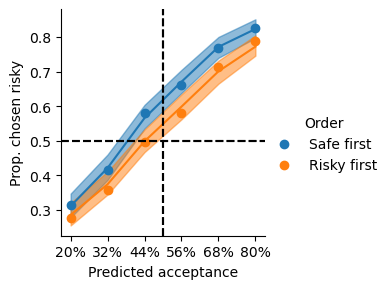

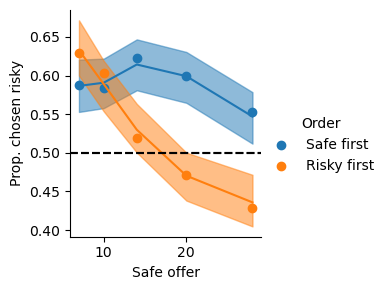

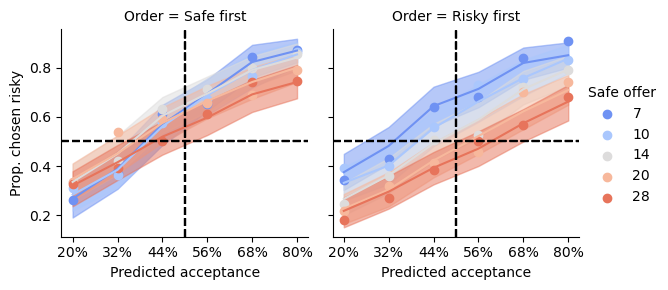

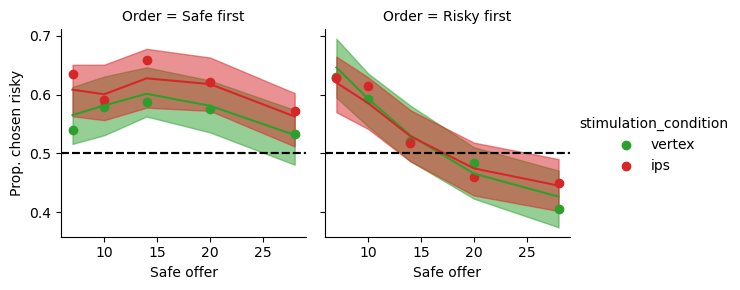

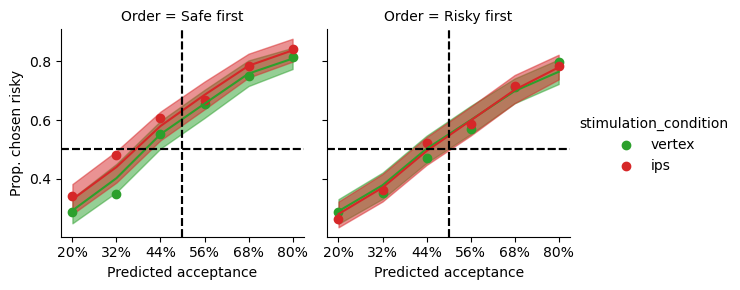

In [13]:
for plot_type in [1,2,3, 5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')

    # plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_ppc{plot_type}.pdf'))

In [11]:
plot_ppc(df, ppc, plot_type=6, level='group')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 1874, in _agg_py_fallback
    res_values = self.grouper.agg_series(ser, alt, preserve_dtype=True)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/groupby/ops.py", line 849, in agg_series
    result = self._aggregate_series_pure_python(obj, func)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/groupby/ops.py", line 877, in _aggregate_series_pure_python
    res = func(group)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/groupby/groupby.py", line 2380, in <lambda>
    alt=lambda x: Series(x).mean(numeric_only=numeric_only),
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/series.py", line 6225, in mean
    return NDFrame.mean(self, axis, skipna, numeric_only, **kwargs)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/generic.py"

In [48]:
plot_ppc(df, ppc, plot_type=7, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


In [ ]:
# Flexible 1c

# Flexible 1 (4 parameters)

In [33]:
df = get_data(model_label='flexible1.4')
model = build_model(df=df, model_label='flexible1.4')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible1.4_trace.netcdf'))

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [34]:
n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values

x = np.arange(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(4)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/4174186402.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/4174186402.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/4174186402.py:2: FutureWarning: In a future version of pandas all arguments of concat exce

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

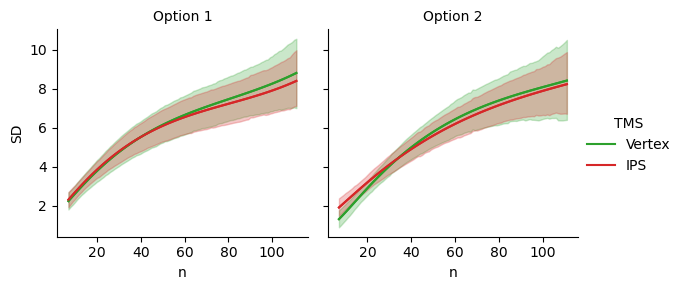

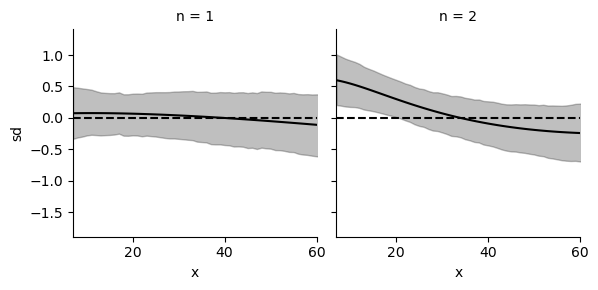

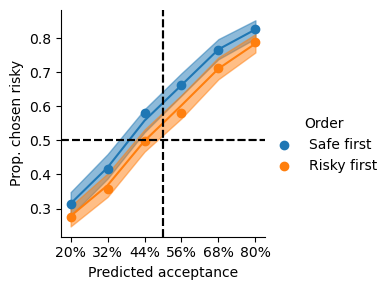

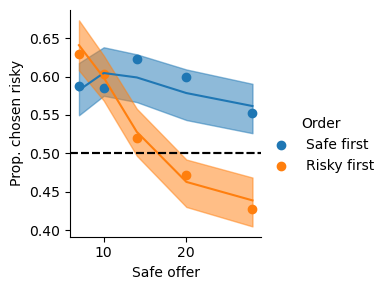

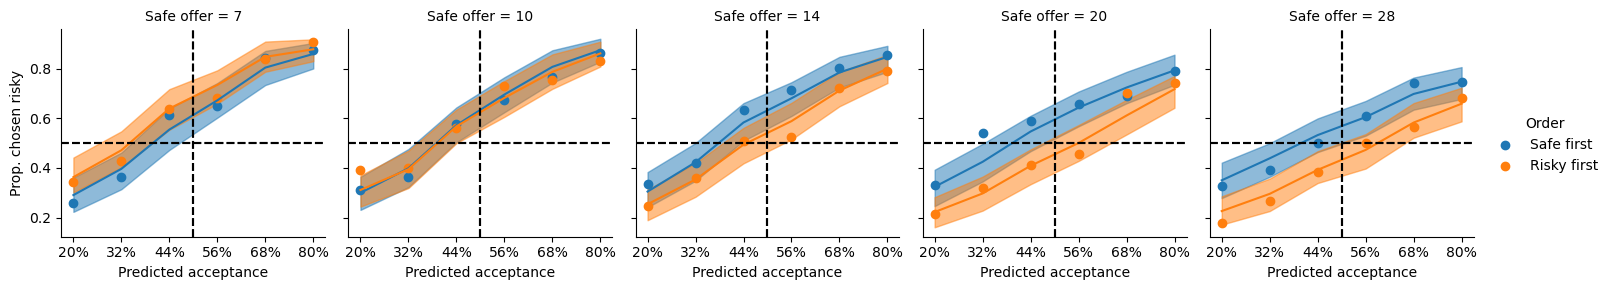

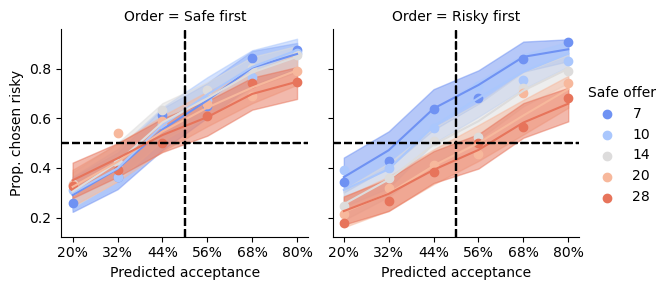

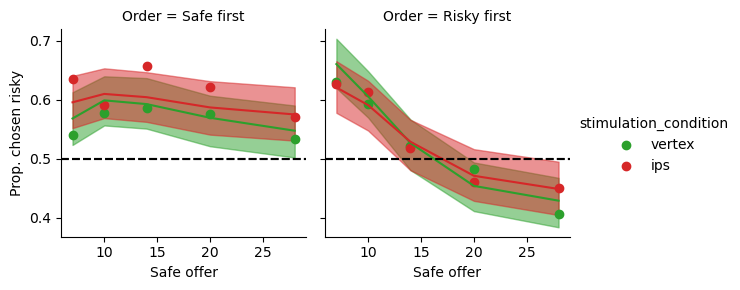

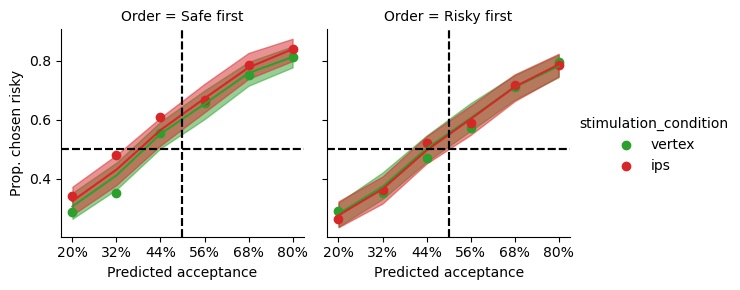

In [35]:
g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_evidence_sd.pdf'))

tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 60)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_evidence_sd_diff.pdf'))



ppc = get_ppc(model, idata, df)
for plot_type in [1,2,3, 5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_ppc{plot_type}.pdf'))

# Flexible 1 null

In [5]:
df = get_data(model_label='flexible1_null')
model = build_model(df=df, model_label='flexible1_null')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible1_null_trace.netcdf'))

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [6]:
x = np.linspace(7, 112)
dm = model.make_dm(x)

n1_evidence_sd = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
n2_evidence_sd = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)


def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd, n2_evidence_sd]:
    d.columns = range(5)

evidence_sd = pd.concat((n1_evidence_sd, n2_evidence_sd, ),axis=0,
                        keys=[1, 2], names=['n'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n'], group_keys=True).apply(get_curve_stats)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/723571541.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/723571541.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n2_evidence_sd = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)


In [7]:
curve_stats

sd    hdi025    hdi975
n x                                       
1 7.000000    1.718895  0.792783  2.324703
  9.142857    1.903386  0.956349  2.478635
  11.285714   2.086206  1.131784  2.637298
  13.428571   2.265994  1.302683  2.796404
  15.571429   2.441765  1.474221  2.953602
...                ...       ...       ...
2 103.428571  7.129272  5.234168  8.414099
  105.571429  7.222255  5.241435  8.476335
  107.714286  7.317143  5.356528  8.648438
  109.857143  7.414320  5.426834  8.804459
  112.000000  7.514165  5.420120  8.947426

[100 rows x 3 columns]

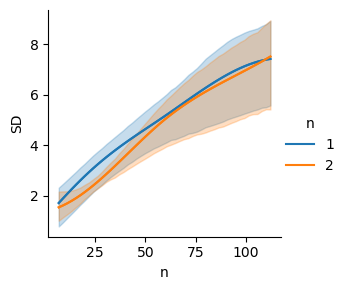

In [8]:
g = sns.FacetGrid(curve_stats.reset_index(), hue='n')
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_null_evidence_sd.pdf'))

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

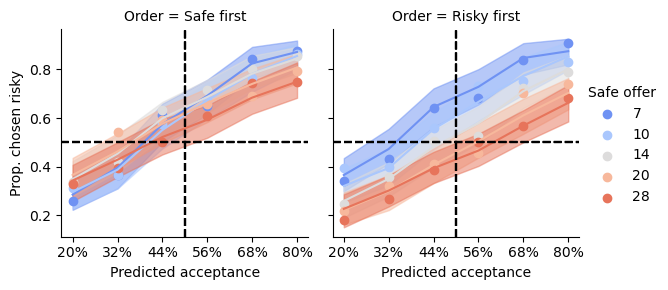

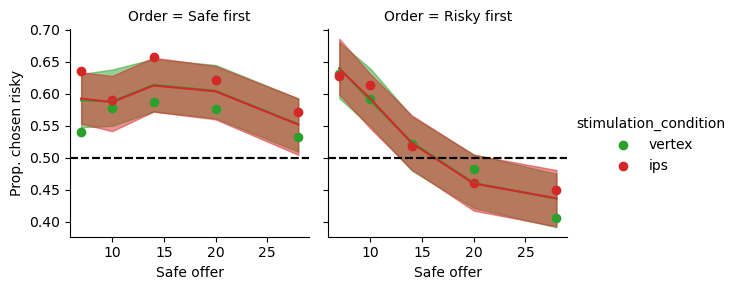

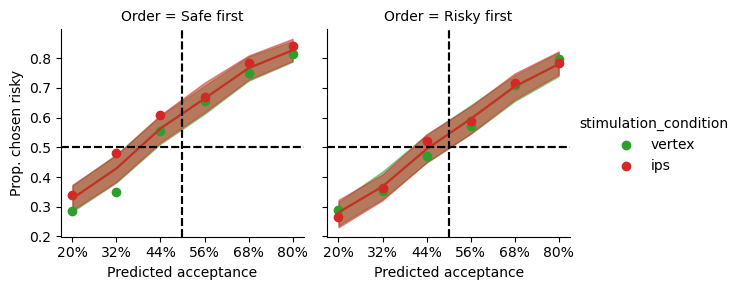

In [9]:
ppc = get_ppc(model, idata, df)
for plot_type in [5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_null_ppc{plot_type}.pdf'))

In [10]:
az.plot_trace(idata)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (57), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'n1_evidence_sd_poly0'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly0'}>],
       [<Axes: title={'center': 'n1_evidence_sd_poly0_mu'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly0_mu'}>],
       [<Axes: title={'center': 'n1_evidence_sd_poly0_offset'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly0_offset'}>],
       [<Axes: title={'center': 'n1_evidence_sd_poly0_sd'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly0_sd'}>],
       [<Axes: title={'center': 'n1_evidence_sd_poly1'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly1'}>],
       [<Axes: title={'center': 'n1_evidence_sd_poly1_mu'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly1_mu'}>],
       [<Axes: title={'center': 'n1_evidence_sd_poly1_offset'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly1_offset'}>],
       [<Axes: title={'center': 'n1_evidence_sd_poly1_sd'}>,
        <Axes: title={'center': 'n1_evidence_sd_poly1_sd'}>],
       [<Axe

Error in callback <function flush_figures at 0x29badba30> (for post_execute):


KeyboardInterrupt: 

# Flexible 1b

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_63795/3608386165.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_63795/3608386165.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_63795/3608386165.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs(

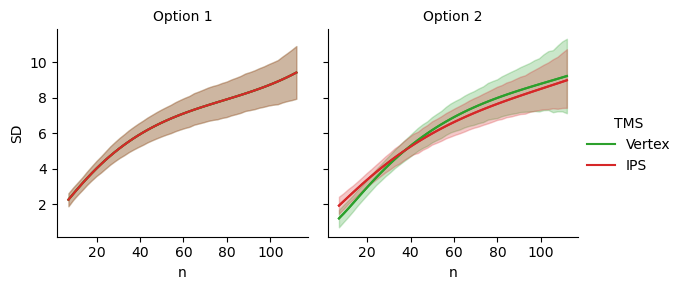

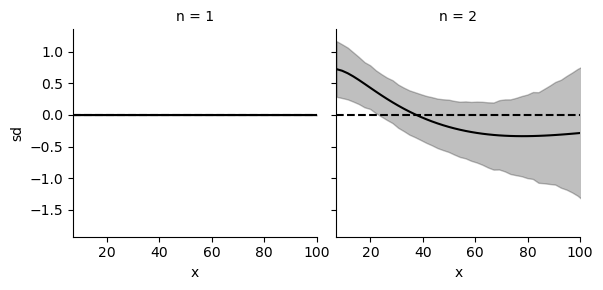

In [14]:
model_label = 'flexible1b.4'
df, model, idata = get_info(model_label)

n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
n1_evidence_sd_vertex = n1_evidence_sd_ips

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values

x = np.linspace(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(4)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd.pdf'))


tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 100)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd_diff.pdf'))

# Flexible 1b (4 parameters)

In [21]:
model_label = 'flexible1b.4'
df, model, idata = get_info(model_label)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [22]:
n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
n1_evidence_sd_vertex = n1_evidence_sd_ips

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/1462665309.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/1462665309.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/1462665309.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n2_evidence_sd_vertex = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('In

In [23]:
x = np.linspace(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(4)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

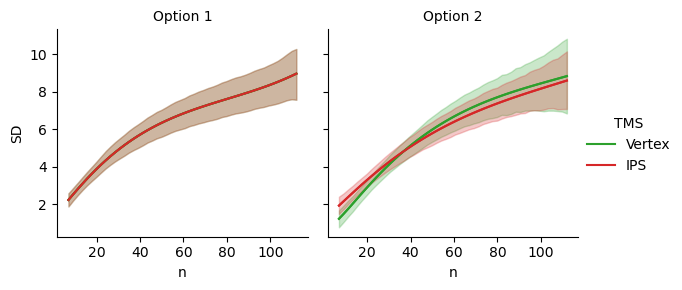

In [24]:
g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd.pdf'))

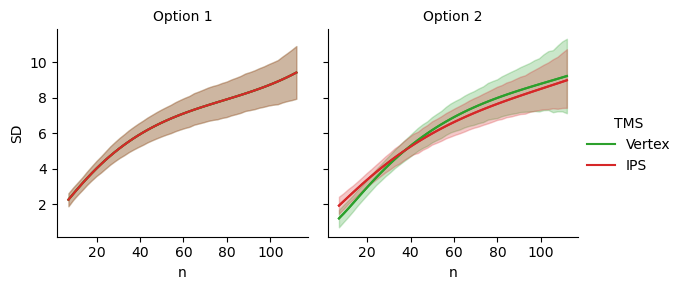

In [9]:
g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd.pdf'))

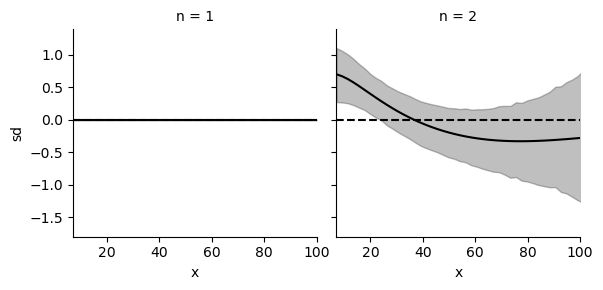

In [25]:
tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 100)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd_diff.pdf'))

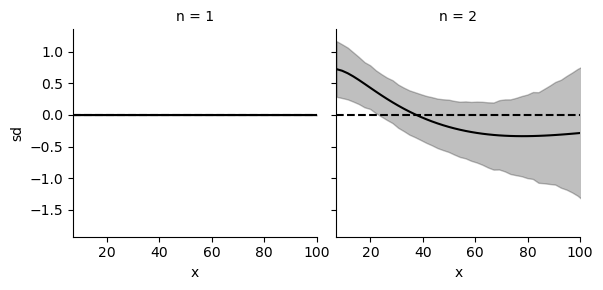

In [10]:
tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 100)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd_diff.pdf'))

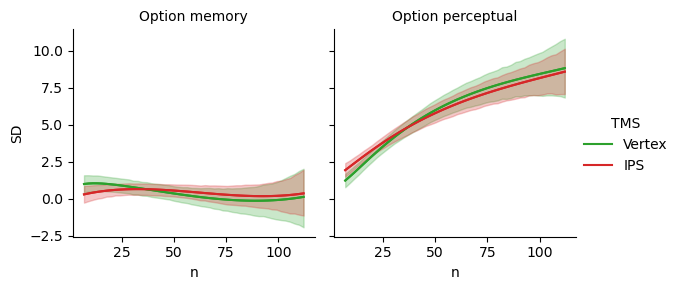

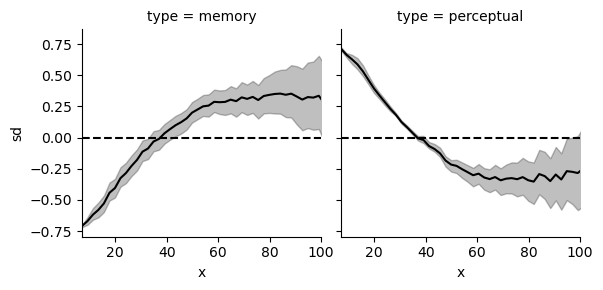

In [26]:
memory_curve_posterior = curve_posterior.loc[1] - curve_posterior.loc[2]
perceptual_curve_posterior = curve_posterior.loc[2]

repar_curve_posterior = pd.concat((memory_curve_posterior, perceptual_curve_posterior), keys=['memory', 'perceptual'], names=['type'], axis=0)

repar_curve_posterior_stats = repar_curve_posterior.groupby(['type', 'TMS']).apply(lambda d: model.get_sd_curve_stats(d.stack().to_frame('sd')))
repar_curve_posterior_stats = repar_curve_posterior.groupby(['type', 'TMS']).apply(lambda d: model.get_sd_curve_stats(d.stack().to_frame('sd')))
g = sns.FacetGrid(repar_curve_posterior_stats.reset_index(), col='type', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_repar_evidence_sd.pdf'))

tmp = repar_curve_posterior_stats.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby=['type'])

g = sns.FacetGrid(diff_stats.reset_index(), col='type')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 100)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1_repar_evidence_sd_diff.pdf'))

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

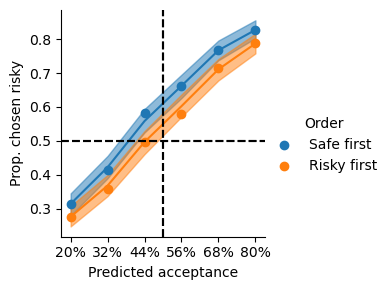

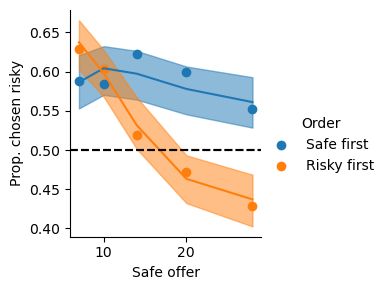

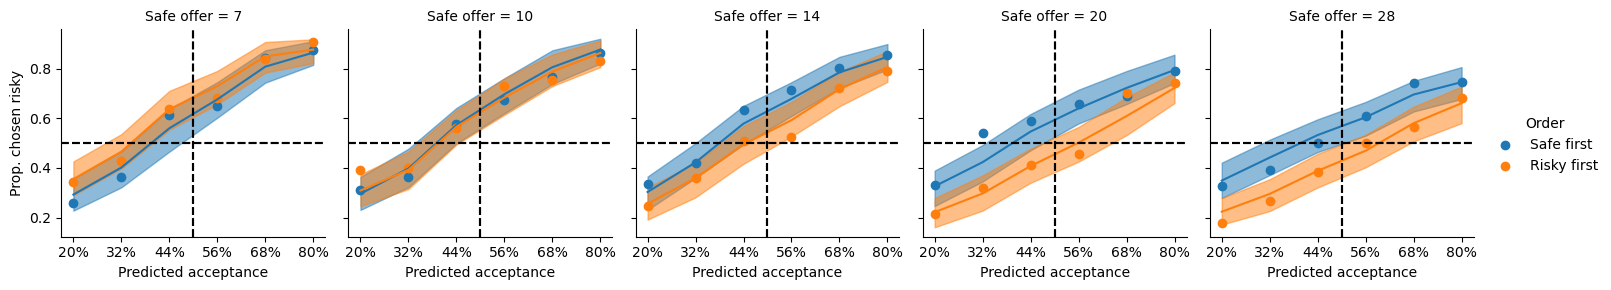

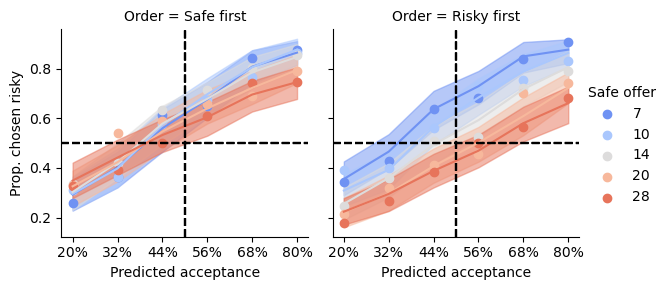

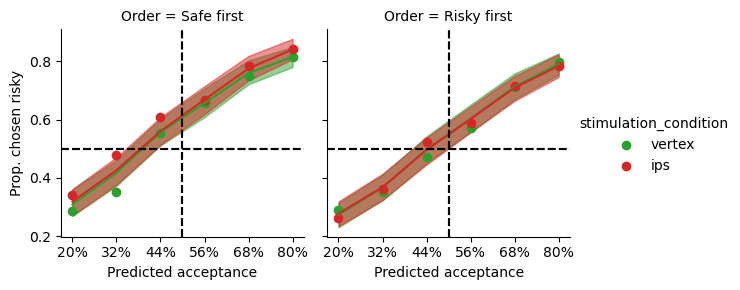

In [27]:
ppc = get_ppc(model, idata, df)
for plot_type in [1,2,3, 5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_ppc{plot_type}.pdf'))

# Flexible 1c

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89903/1852394897.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89903/1852394897.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(n_pars)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89903/1852394897.py:8: FutureWarning: In a future version of pandas all argume

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

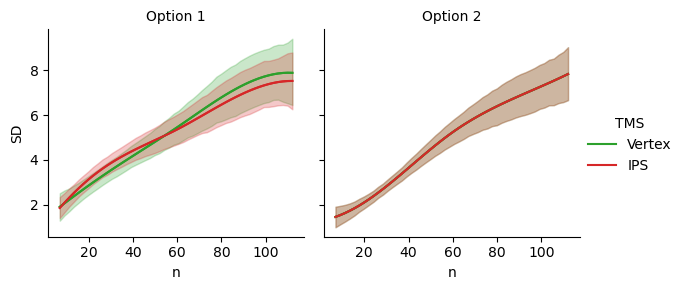

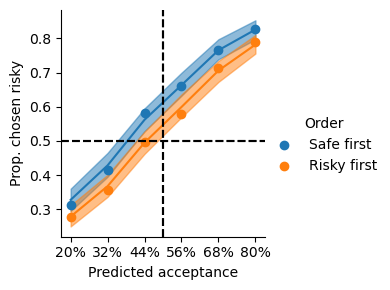

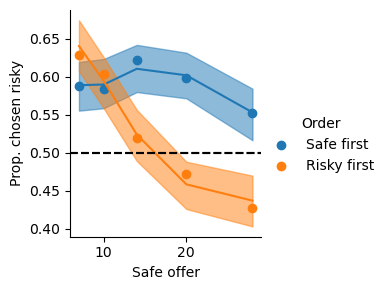

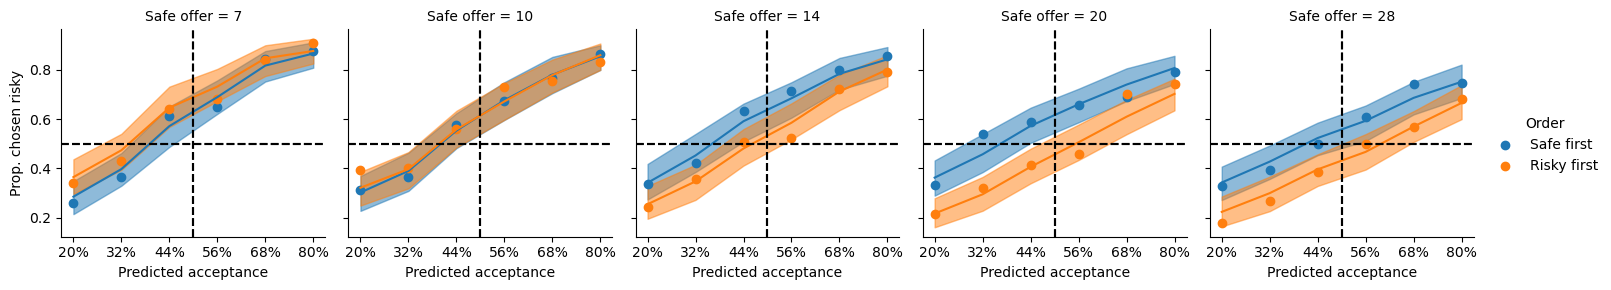

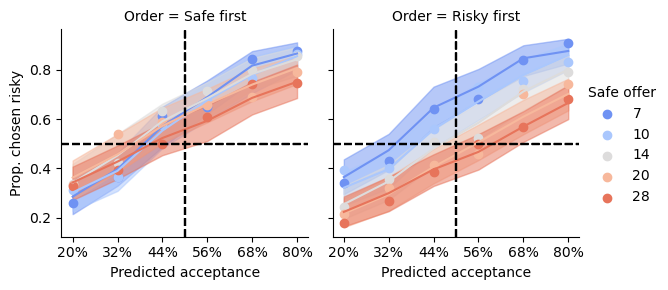

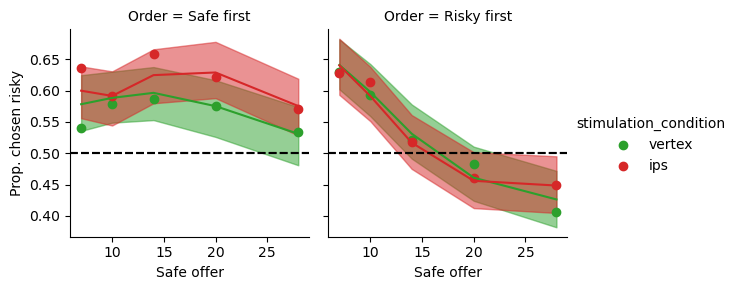

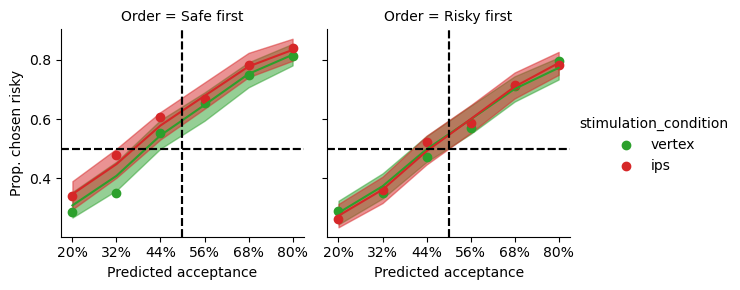

In [9]:
model_label = 'flexible1c'

n_pars = 4 if model_label.endswith('4') else 5

df, model, idata = get_info(model_label)

n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1)
n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(n_pars)], 1).values

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1)
n2_evidence_sd_vertex = n2_evidence_sd_ips

x = np.linspace(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(n_pars)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd.pdf'))


tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 100)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd_diff.pdf'))


ppc = get_ppc(model, idata, df)
for plot_type in [1,2,3, 5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_ppc{plot_type}.pdf'))

# Flexible 1c (4 parameters)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/1872722920.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/1872722920.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(n_pars)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_1976/1872722920.py:7: FutureWarning: In a future version of pandas all arguments

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

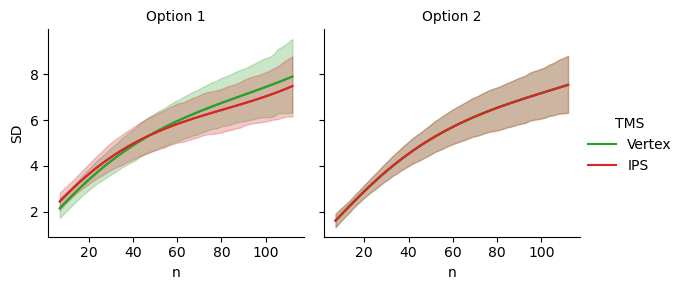

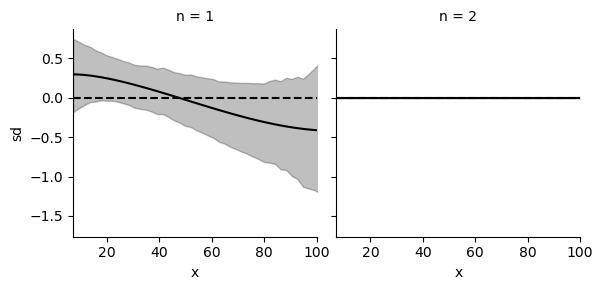

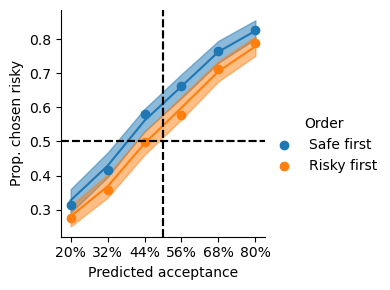

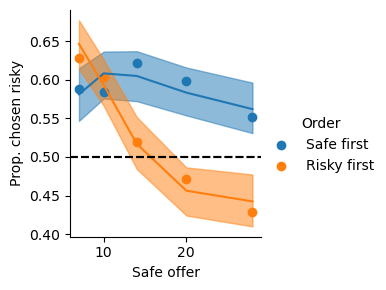

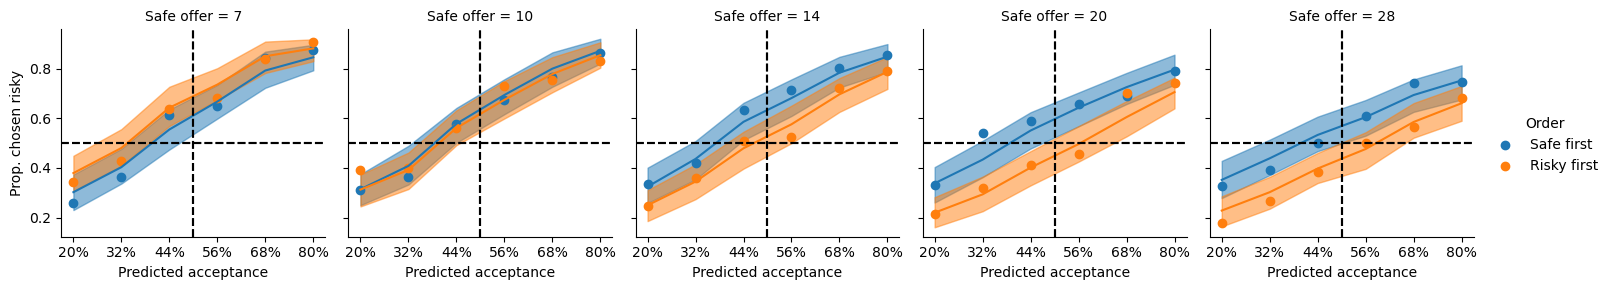

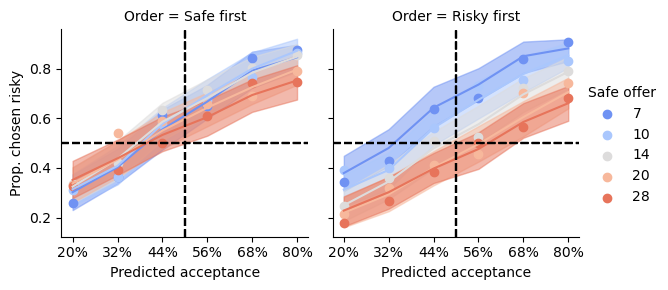

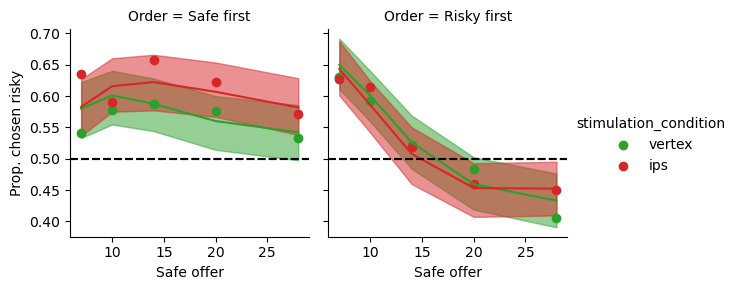

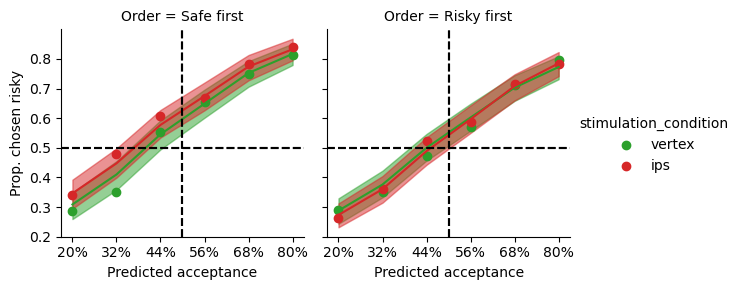

In [28]:
model_label = 'flexible1c.4'
n_pars = 4

df, model, idata = get_info(model_label)

n1_evidence_sd_ips = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1)
n1_evidence_sd_vertex = pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1) + pd.concat([idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(n_pars)], 1).values

n2_evidence_sd_ips = pd.concat([idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(n_pars)], 1)
n2_evidence_sd_vertex = n2_evidence_sd_ips

x = np.linspace(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)

def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

for d in [n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex]:
    d.columns = range(4)

evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex, n2_evidence_sd_ips, n2_evidence_sd_vertex),axis=0,
                        keys=[(1, 'IPS'), (1, 'Vertex'), (2, 'IPS'), (2, 'Vertex')], names=['n', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['n', 'TMS'], group_keys=True).apply(get_curve_stats)

g = sns.FacetGrid(curve_stats.reset_index(), col='n', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd.pdf'))


tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby='n')

g = sns.FacetGrid(diff_stats.reset_index(), col='n')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 100)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_evidence_sd_diff.pdf'))


ppc = get_ppc(model, idata, df)
for plot_type in [1,2,3, 5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible1b_ppc{plot_type}.pdf'))

In [29]:
with model.estimation_model:
    prior = pm.sample_prior_predictive()
    idata.extend(prior)

Sampling: [ll_bernoulli, n1_evidence_sd_poly0_mu, n1_evidence_sd_poly0_offset, n1_evidence_sd_poly0_sd, n1_evidence_sd_poly1_mu, n1_evidence_sd_poly1_offset, n1_evidence_sd_poly1_sd, n1_evidence_sd_poly2_mu, n1_evidence_sd_poly2_offset, n1_evidence_sd_poly2_sd, n1_evidence_sd_poly3_mu, n1_evidence_sd_poly3_offset, n1_evidence_sd_poly3_sd, n2_evidence_sd_poly0_mu, n2_evidence_sd_poly0_offset, n2_evidence_sd_poly0_sd, n2_evidence_sd_poly1_mu, n2_evidence_sd_poly1_offset, n2_evidence_sd_poly1_sd, n2_evidence_sd_poly2_mu, n2_evidence_sd_poly2_offset, n2_evidence_sd_poly2_sd, n2_evidence_sd_poly3_mu, n2_evidence_sd_poly3_offset, n2_evidence_sd_poly3_sd, risky_prior_mu_mu, risky_prior_mu_offset, risky_prior_mu_sd, risky_prior_std_mu, risky_prior_std_offset, risky_prior_std_sd, safe_prior_mu_mu, safe_prior_mu_offset, safe_prior_mu_sd, safe_prior_std_mu, safe_prior_std_offset, safe_prior_std_sd]


array([[<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly0\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly0\nstimulation_condition[T.vertex]'>]],
      dtype=object)

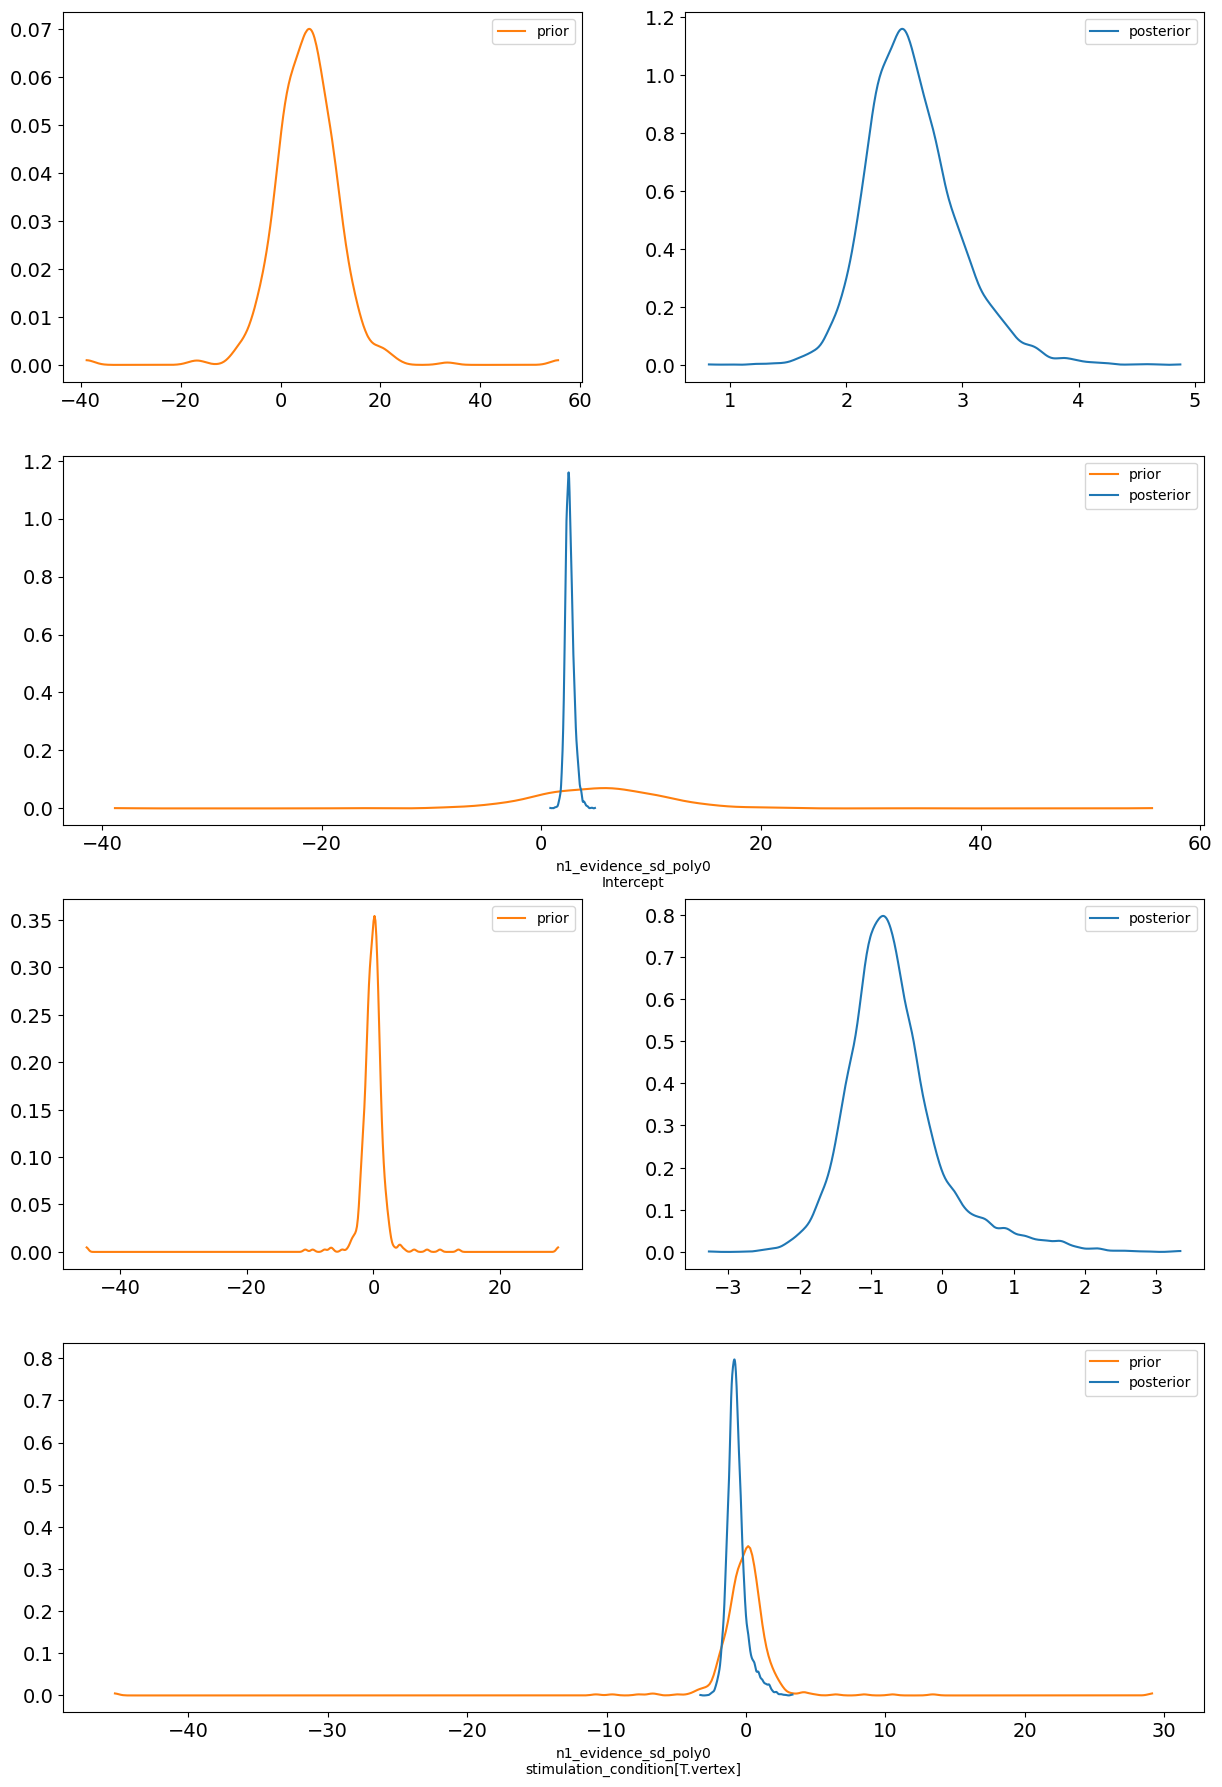

In [30]:
az.plot_dist_comparison(idata, var_names=[f'n1_evidence_sd_poly{ix}' for ix in range(1)], coords={'subject':2})

array([[<Axes: >, <Axes: >,
        <Axes: xlabel='risky_prior_mu_mu\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='risky_prior_mu_sd\nIntercept'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='safe_prior_mu_mu\nIntercept'>],
       [<Axes: >, <Axes: >, <Axes: xlabel='safe_prior_mu_sd\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='risky_prior_std_mu\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='safe_prior_std_mu\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='risky_prior_std_sd\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='safe_prior_std_sd\nIntercept'>]], dtype=object)

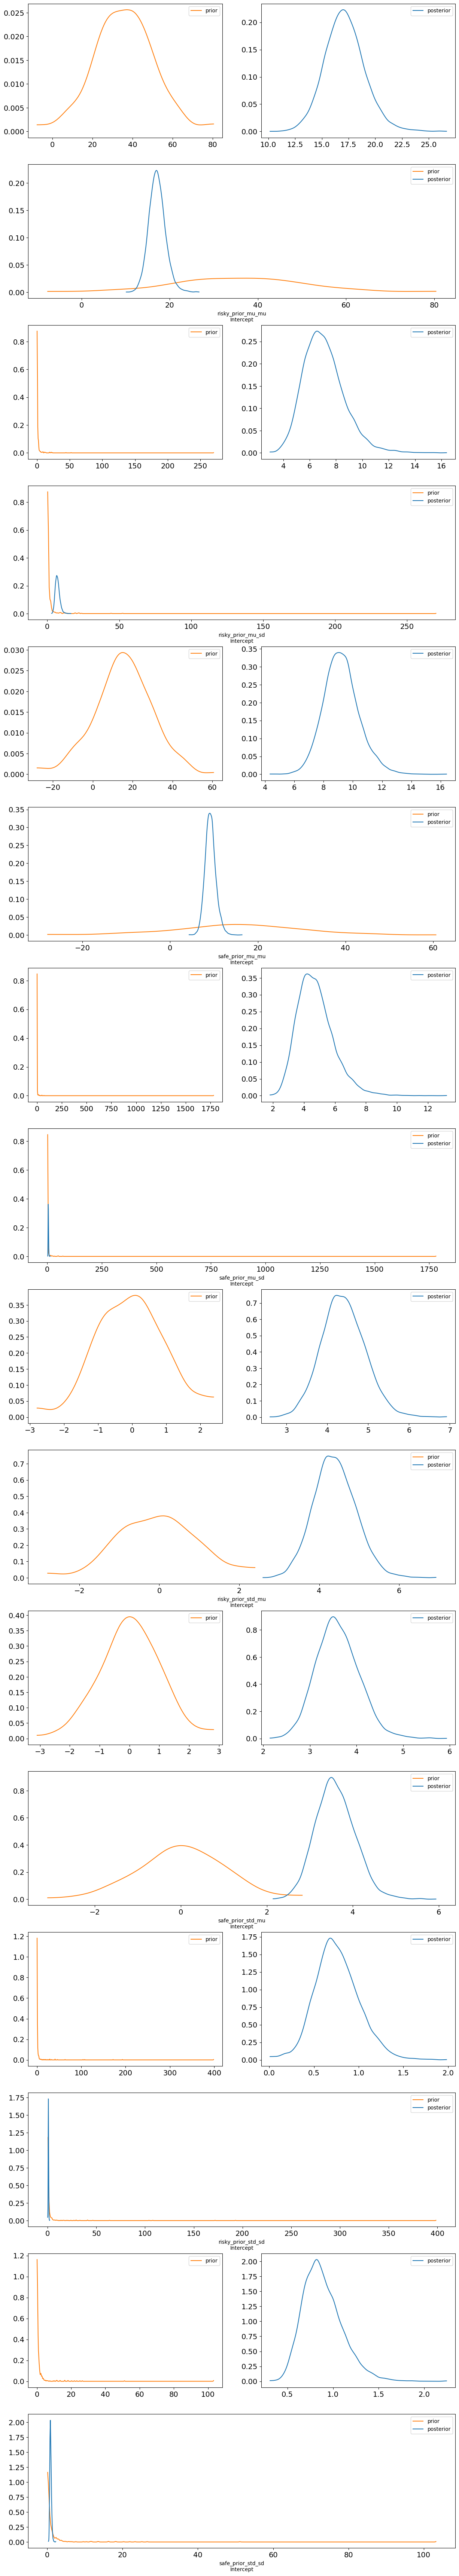

In [31]:
az.plot_dist_comparison(idata, var_names=[f'risky_prior_mu_mu', 'risky_prior_mu_sd', 'safe_prior_mu_mu', 'safe_prior_mu_sd', 'risky_prior_std_mu', 'safe_prior_std_mu', 'risky_prior_std_sd', 'safe_prior_std_sd'])

array([[<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly0_mu\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly0_mu\nstimulation_condition[T.vertex]'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly1_mu\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly1_mu\nstimulation_condition[T.vertex]'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly2_mu\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly2_mu\nstimulation_condition[T.vertex]'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly3_mu\nIntercept'>],
       [<Axes: >, <Axes: >,
        <Axes: xlabel='n1_evidence_sd_poly3_mu\nstimulation_condition[T.vertex]'>]],
      dtype=object)

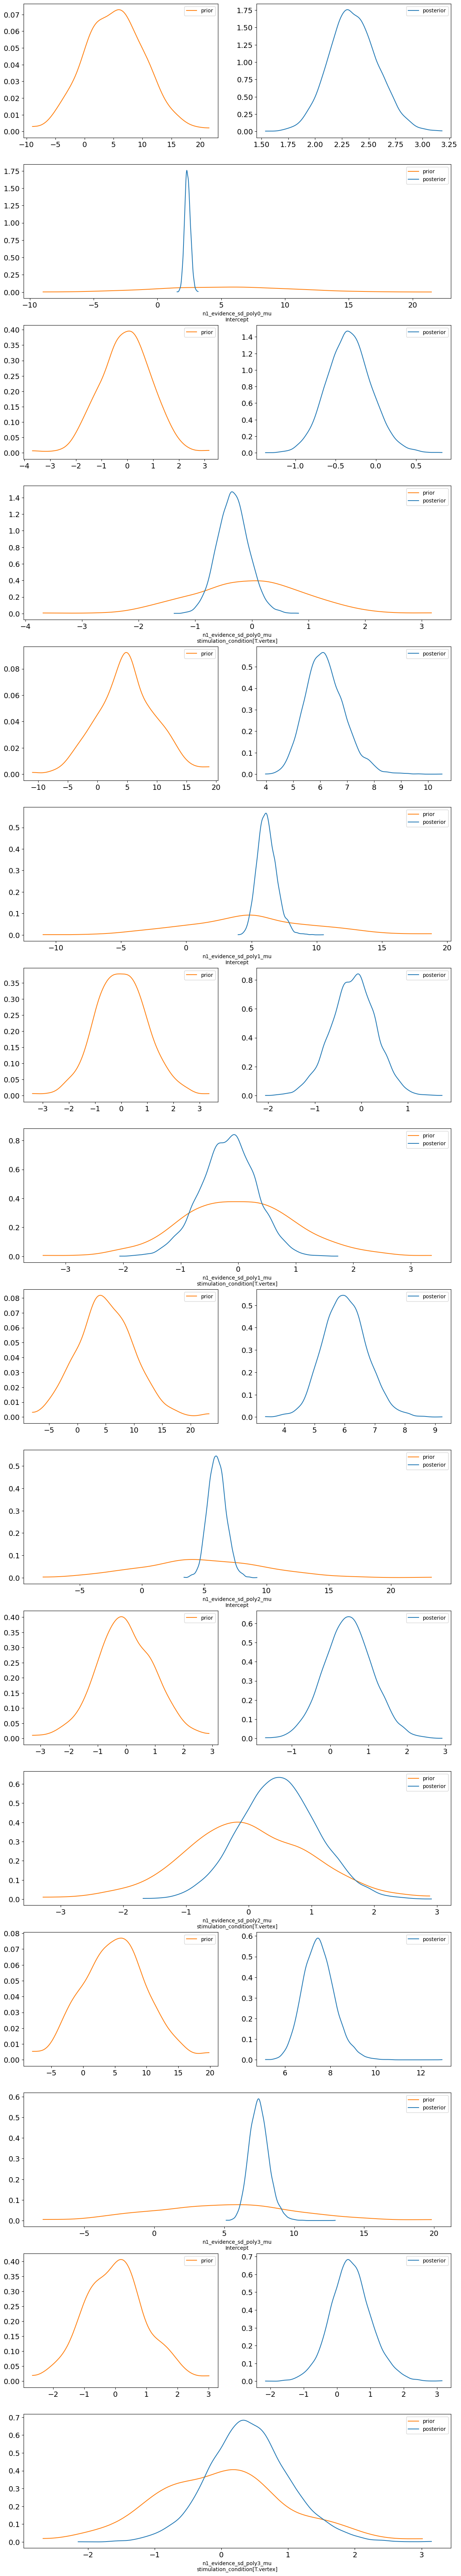

In [32]:
az.plot_dist_comparison(idata, var_names=[f'n1_evidence_sd_poly{ix}_mu' for ix in range(n_pars)])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89903/49120385.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89903/49120385.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147

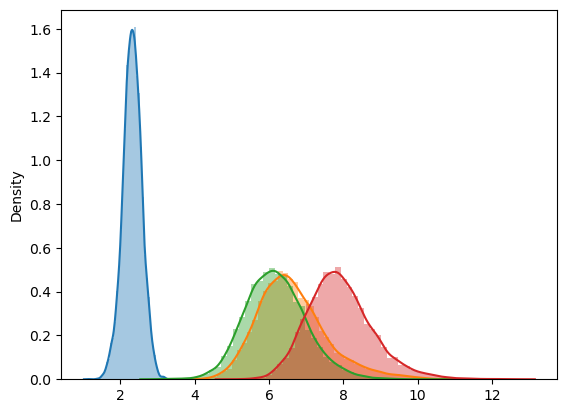

In [43]:
for ix in range(n_pars):
    sns.distplot(idata.posterior[f'n1_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89903/4133245332.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1))
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_89903/4133245332.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de4

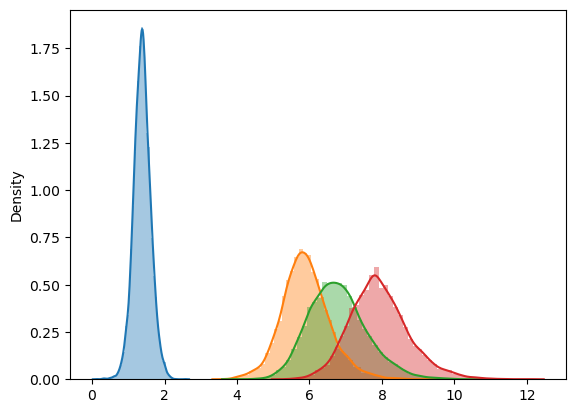

In [44]:
for ix in range(n_pars):
    sns.distplot(idata.posterior[f'n2_evidence_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1))

# Flexible 2

In [41]:
df = get_data(model_label='flexible2')
model = build_model(df=df, model_label='flexible2')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible2_trace.netcdf'))


/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/Users/gdehol/mambaforge/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (57), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'memory_noise_sd_poly0'}>,
        <Axes: title={'center': 'memory_noise_sd_poly0'}>],
       [<Axes: title={'center': 'memory_noise_sd_poly0_mu'}>,
        <Axes: title={'center': 'memory_noise_sd_poly0_mu'}>],
       [<Axes: title={'center': 'memory_noise_sd_poly0_offset'}>,
        <Axes: title={'center': 'memory_noise_sd_poly0_offset'}>],
       [<Axes: title={'center': 'memory_noise_sd_poly0_sd'}>,
        <Axes: title={'center': 'memory_noise_sd_poly0_sd'}>],
       [<Axes: title={'center': 'memory_noise_sd_poly1'}>,
        <Axes: title={'center': 'memory_noise_sd_poly1'}>],
       [<Axes: title={'center': 'memory_noise_sd_poly1_mu'}>,
        <Axes: title={'center': 'memory_noise_sd_poly1_mu'}>],
       [<Axes: title={'center': 'memory_noise_sd_poly1_offset'}>,
        <Axes: title={'center': 'memory_noise_sd_poly1_offset'}>],
       [<Axes: title={'center': 'memory_noise_sd_poly1_sd'}>,
        <Axes: title={'center': 'memory_noise_sd_poly1_sd'}

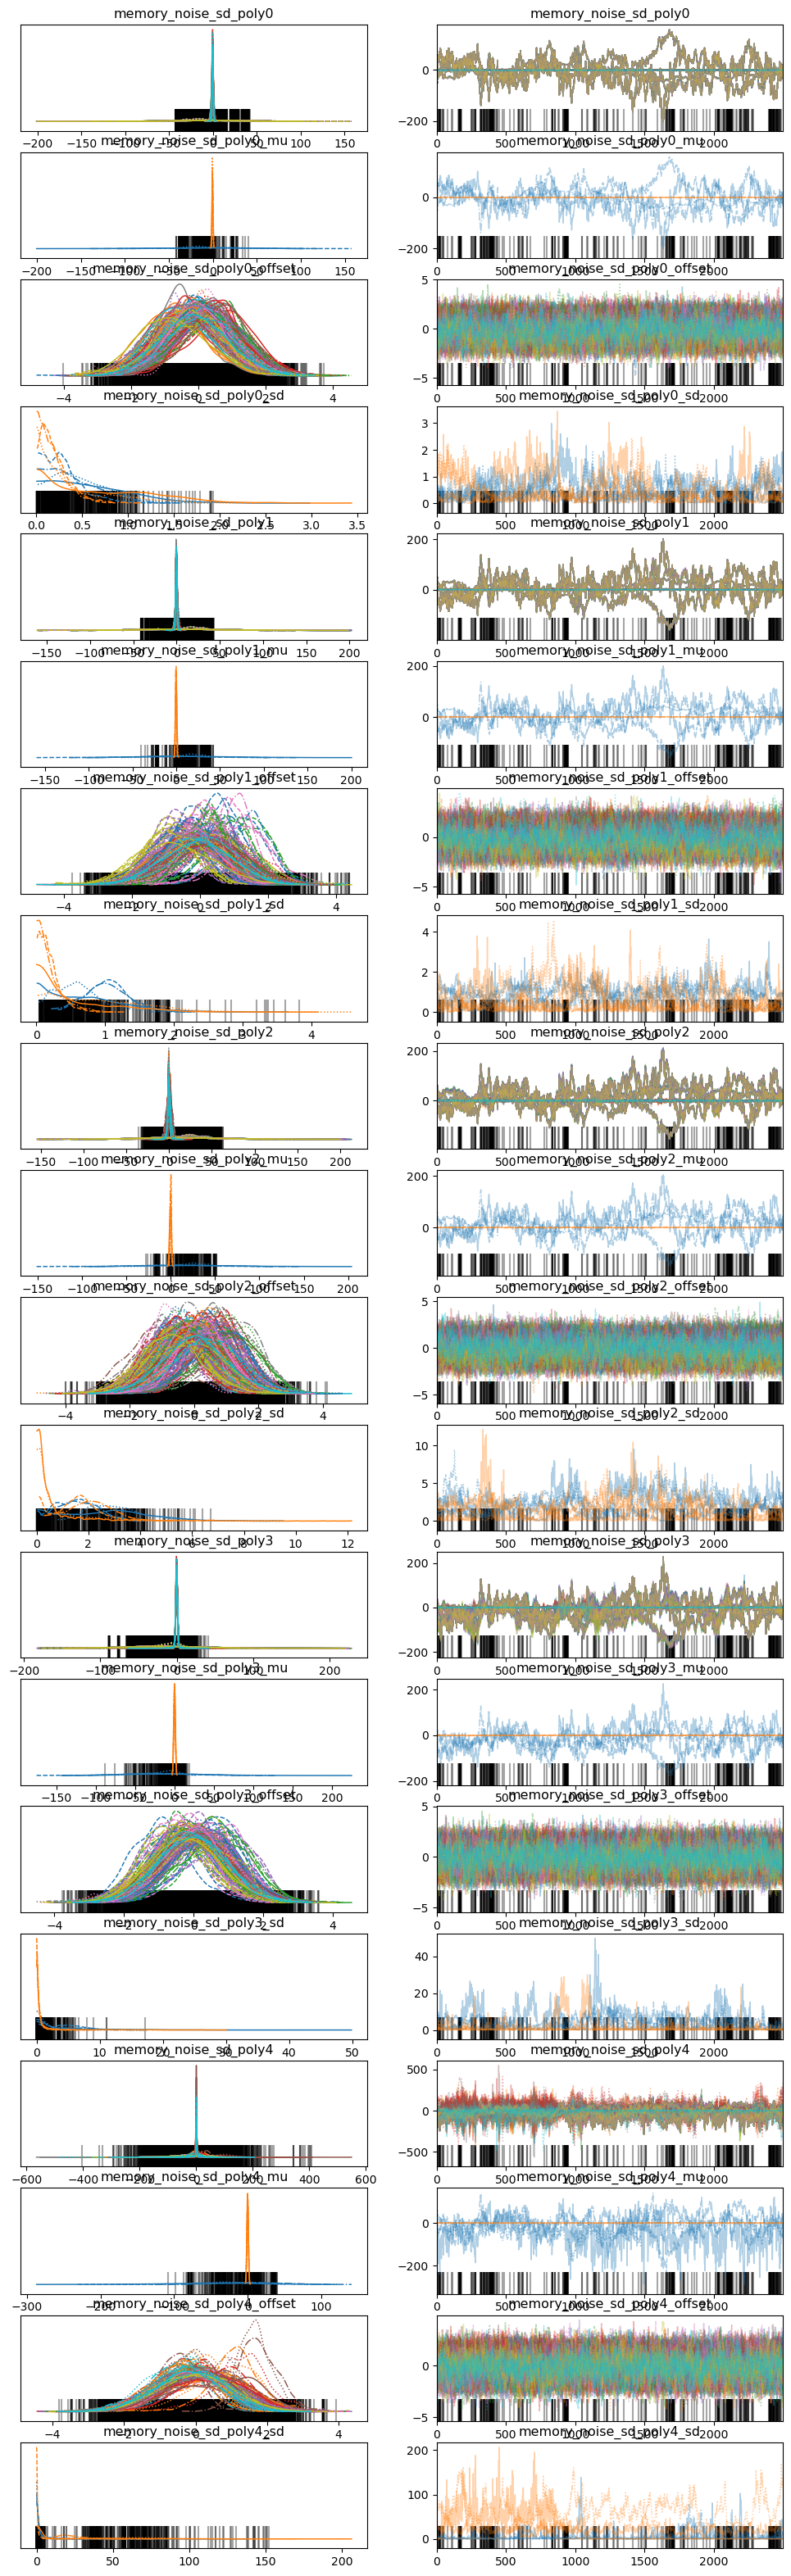

In [42]:
az.plot_trace(idata)

In [43]:
perceptual_noise_sd_ips = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
perceptual_noise_sd_vertex = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

memory_noise_sd_ips = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
memory_noise_sd_vertex = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87348/624700234.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  perceptual_noise_sd_ips = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87348/624700234.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  perceptual_noise_sd_vertex = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(5)], 1) + pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(5)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_87348/624700234.py:2: FutureWarning: In a future version of pandas all

In [44]:
x = np.arange(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)


def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

def get_ppc(model, idata, df):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

    return ppc

for d in [perceptual_noise_sd_ips, perceptual_noise_sd_vertex, memory_noise_sd_ips, memory_noise_sd_vertex]:
    d.columns = range(5)

evidence_sd = pd.concat([perceptual_noise_sd_ips, perceptual_noise_sd_vertex, memory_noise_sd_ips, memory_noise_sd_vertex], axis=0,
                        keys=[('perceptual', 'IPS'), ('perceptual', 'Vertex'), ('memory', 'IPS'), ('memory', 'Vertex')], names=['noise', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['noise', 'TMS'], group_keys=True).apply(get_curve_stats)

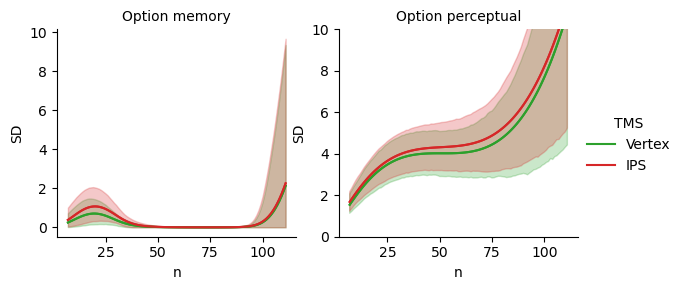

In [45]:
g = sns.FacetGrid(curve_stats.reset_index(), col='noise', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order, sharey=False)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()
plt.ylim(0, 10)

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible2_evidence_sd.pdf'))

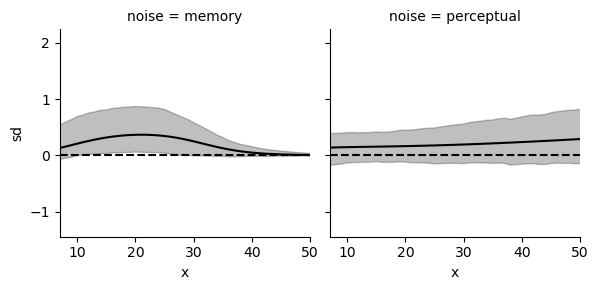

In [46]:
tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby=['noise'])

g = sns.FacetGrid(diff_stats.reset_index(), col='noise')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 50)

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible2_evidence_sd_diff.pdf'))

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

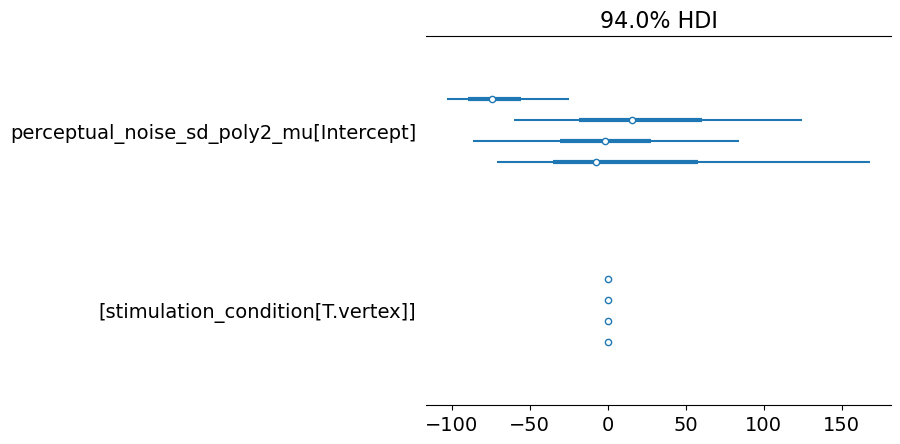

In [47]:
az.plot_forest(idata.posterior, var_names=['perceptual_noise_sd_poly2_mu'], combined=False)

array([[<Axes: title={'center': 'memory_noise_sd_poly0'}>,
        <Axes: title={'center': 'memory_noise_sd_poly0'}>]], dtype=object)

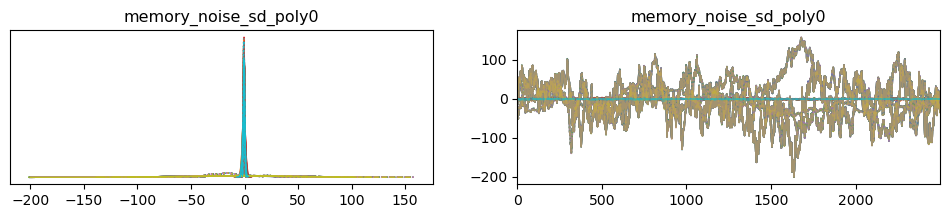

In [48]:
az.plot_trace(idata.posterior, var_names=['memory_noise_sd_poly0'])

In [49]:
pars = get_pars(idata.sel())

p
g = plot_pars(pars, df)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible2_pars.pdf'))

risky_prior_mu_mu
risky_prior_std_mu
safe_prior_mu_mu
safe_prior_std_mu


NameError: name 'p' is not defined

# Flexible 2 (4 parameters)

In [21]:
df = get_data(model_label='flexible2.4')
model = build_model(df=df, model_label='flexible2.4')

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-flexible2.4_trace.netcdf'))
perceptual_noise_sd_ips = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
perceptual_noise_sd_vertex = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values

memory_noise_sd_ips = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
memory_noise_sd_vertex = pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'memory_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_63795/1603296037.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  perceptual_noise_sd_ips = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_63795/1603296037.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  perceptual_noise_sd_vertex = pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('Intercept', 0, -1) for ix in range(4)], 1) + pd.concat([idata.posterior[f'perceptual_noise_sd_poly{ix}_mu'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1) for ix in range(4)], 1).values
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_63795/1603296037.py:6: FutureWarning: In a future version of pandas 

In [26]:
az.plot_trace(idata)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (49), generating only 20 plots
  warnings.warn(


In [23]:
x = np.arange(7, 112)
dm = model.make_dm(x)

def get_curve_posterior(evidence_sd_posterior):
    curve_posterior = evidence_sd_posterior.dot(dm.T)
    curve_posterior.columns = x
    curve_posterior.columns.name = 'x'

    return softplus_np(curve_posterior)


def get_curve_stats(evidence_sd_posterior):
    curve_posterior = get_curve_posterior(evidence_sd_posterior)

    return model.get_sd_curve_stats(curve_posterior.stack().to_frame('sd'))

def get_ppc(model, idata, df):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

    return ppc

for d in [perceptual_noise_sd_ips, perceptual_noise_sd_vertex, memory_noise_sd_ips, memory_noise_sd_vertex]:
    d.columns = range(4)

evidence_sd = pd.concat([perceptual_noise_sd_ips, perceptual_noise_sd_vertex, memory_noise_sd_ips, memory_noise_sd_vertex], axis=0,
                        keys=[('perceptual', 'IPS'), ('perceptual', 'Vertex'), ('memory', 'IPS'), ('memory', 'Vertex')], names=['noise', 'TMS'])

curve_posterior = get_curve_posterior(evidence_sd)
curve_stats = evidence_sd.groupby(['noise', 'TMS'], group_keys=True).apply(get_curve_stats)

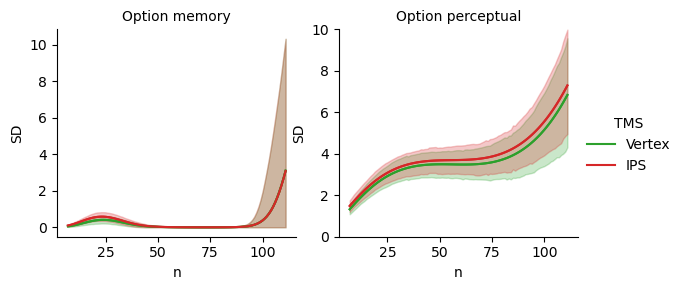

In [24]:
g = sns.FacetGrid(curve_stats.reset_index(), col='noise', hue='TMS', palette=stimulation_palette, col_wrap=2, hue_order=stimulation_order, sharey=False)
g.map_dataframe(plot_prediction, x='x', y='sd')
g.map(plt.plot, 'x', 'sd')

g.set_titles('Option {col_name}')
g.set(ylabel='SD', xlabel='n')
g.add_legend()
plt.ylim(0, 10)

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible2_evidence_sd.pdf'))

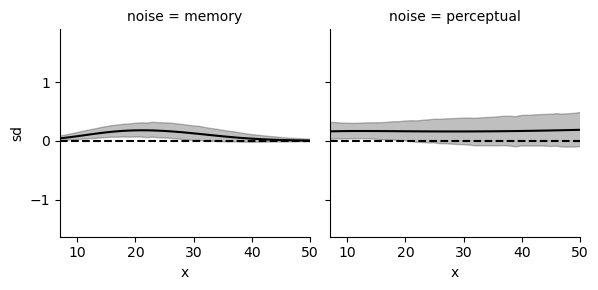

In [25]:
tmp = curve_posterior.stack().to_frame('sd').unstack('TMS')['sd']

diff = tmp['IPS'] - tmp['Vertex']

diff_stats = model.get_sd_curve_stats(diff.to_frame('sd'), groupby=['noise'])

g = sns.FacetGrid(diff_stats.reset_index(), col='noise')

g.map_dataframe(plot_prediction, x='x', y='sd', color='k')
g.map(lambda *args, **kwargs: plt.axhline(0, color='k', linestyle='--'))

plt.xlim(7, 50)

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-flexible2_evidence_sd_diff.pdf'))